In [1]:
import os
import json
import pandas as pd

json_folder = 'Sample/02.라벨링데이터'
rows = []

for filename in os.listdir(json_folder):
    if filename.endswith('.json'):
        with open(os.path.join(json_folder, filename), 'r', encoding='utf-8') as f:
            try:
                data = json.load(f)
                wav_id = data.get('File', {}).get('FileName', '') + '.wav'
                conversations = data.get('Conversation', [])

                for conv in conversations:
                    try:
                        # 쉼표 제거 후 float 변환
                        start_time = float(conv.get('StartTime', '0').replace(',', ''))
                        end_time = float(conv.get('EndTime', '0').replace(',', ''))
                        emotion = conv.get('SpeakerEmotionCategory', 'unknown')

                        rows.append({
                            'wav_id': wav_id,
                            'start_time': start_time,
                            'end_time': end_time,
                            'Text': conv.get('Text', '').strip(),
                            'emotion': emotion
                        })
                    except ValueError as e:
                        print(f"⚠️ 대화 오류 in {filename}: {e}")
                        continue

            except Exception as e:
                print(f"⚠️ 파일 오류 in {filename}: {e}")
                continue
                
# ✅ DataFrame 생성
df = pd.DataFrame(rows)

# ✅ 감정 레이블 숫자 변환
label_map = {'긍정': 0, '중립': 1, '부정': 1}
df['emotion'] = df['emotion'].map(label_map)

print(df.head(10))

                                              wav_id  start_time  end_time  \
0  2_1397G1A4_1398G2A6_T1_2D06T0221C000476_005157...        5.70      6.98   
1  2_1397G1A4_1398G2A6_T1_2D06T0221C000476_005157...        6.05      6.83   
2  2_1397G1A4_1398G2A6_T1_2D06T0221C000476_005157...        6.95      9.98   
3  2_1397G1A4_1398G2A6_T1_2D06T0221C000476_005157...        7.50      8.73   
4  2_1397G1A4_1398G2A6_T1_2D06T0221C000476_005157...       10.10     12.23   
5  2_1397G1A4_1398G2A6_T1_2D06T0221C000476_005157...       10.45     11.83   
6  2_1397G1A4_1398G2A6_T1_2D06T0221C000476_005157...       13.05     15.88   
7  2_1397G1A4_1398G2A6_T1_2D06T0221C000476_005157...       15.65     17.28   
8  2_1397G1A4_1398G2A6_T1_2D06T0221C000476_005157...       16.30     17.43   
9  2_1397G1A4_1398G2A6_T1_2D06T0221C000476_005157...       17.00     18.93   

            Text  emotion  
0              어        1  
1              어        1  
2     제가 출장을 가면은        1  
3             제가        1  
4

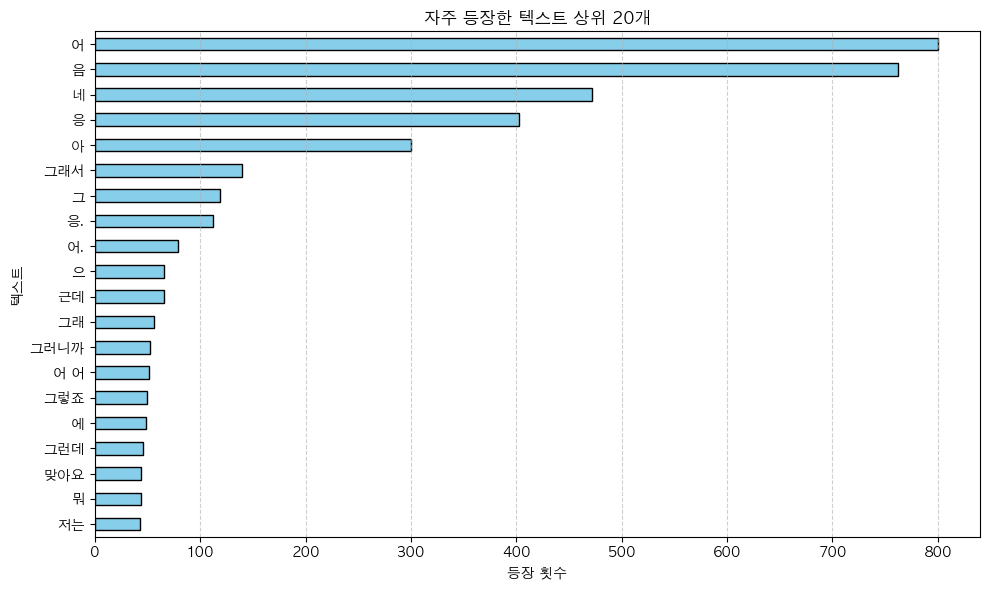

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 애플고딕 폰트 설정 (macOS 기준)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 텍스트별 등장 횟수
text_counts = df['Text'].value_counts().head(20)

# 바 플롯
plt.figure(figsize=(10, 6))
text_counts.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('자주 등장한 텍스트 상위 20개')
plt.xlabel('등장 횟수')
plt.ylabel('텍스트')
plt.gca().invert_yaxis()  # 가장 많이 등장한 것이 위로 가도록

plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [3]:
# 제거 대상 리스트
remove_texts = ['어', '음', '그', '어.', '어 어', '네', '응', '아', '그래서', '그', '응.', '어.', '으', '근데', '그래', '그러니까', '그렇죠', '에', '그런데', '맞아요', '뭐', '저는']

# 제거한 새로운 DataFrame 생성
df_sampled = df[~df['Text'].isin(remove_texts)]

# 1. 긍정 감정만 따로 선택
df_positive = df_sampled[df_sampled['emotion'] == 0]

# 2. 긍정 감정 중 1/3만 랜덤 추출
df_positive_reduced = df_positive.sample(frac=1/2, random_state=42)

# 3. 긍정 이외(중립 + 부정) 데이터 선택
df_others = df_sampled[df_sampled['emotion'] == 1]

# 4. 다시 합치기
df_sampled = pd.concat([df_positive_reduced, df_others]).reset_index(drop=True)
df_sampled = df_sampled.sample(frac=0.5, random_state=42).reset_index(drop=True)

# ✅ 확인
print(df_sampled['emotion'].value_counts())


emotion
0    3977
1    3926
Name: count, dtype: int64


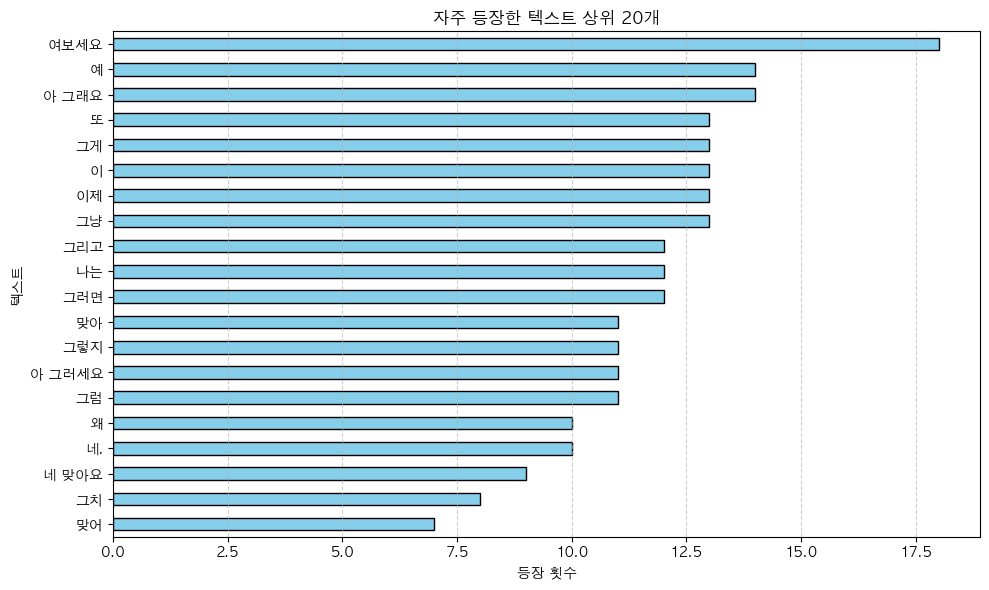

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 애플고딕 폰트 설정 (macOS 기준)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 텍스트별 등장 횟수
text_counts = df_sampled['Text'].value_counts().head(20)

# 바 플롯
plt.figure(figsize=(10, 6))
text_counts.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('자주 등장한 텍스트 상위 20개')
plt.xlabel('등장 횟수')
plt.ylabel('텍스트')
plt.gca().invert_yaxis()  # 가장 많이 등장한 것이 위로 가도록

plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from jamo import h2j
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.init as init

# 자모 사전 정의
jamo_to_idx = {
    '_': 0, '~': 1, 'ㄱ': 2, 'ㄲ': 3, 'ㄴ': 4, 'ㄷ': 5, 'ㄸ': 6, 'ㄹ': 7, 'ㅁ': 8, 'ㅂ': 9,
    'ㅃ': 10, 'ㅅ': 11, 'ㅆ': 12, 'ㅇ': 13, 'ㅈ': 14, 'ㅉ': 15, 'ㅊ': 16, 'ㅋ': 17, 'ㅌ': 18, 'ㅍ': 19,
    'ㅎ': 20, 'ㅏ': 21, 'ㅐ': 22, 'ㅑ': 23, 'ㅒ': 24, 'ㅓ': 25, 'ㅔ': 26, 'ㅕ': 27, 'ㅖ': 28, 'ㅗ': 29,
    'ㅘ': 30, 'ㅙ': 31, 'ㅚ': 32, 'ㅛ': 33, 'ㅜ': 34, 'ㅝ': 35, 'ㅞ': 36, 'ㅟ': 37, 'ㅠ': 38, 'ㅡ': 39,
    'ㅢ': 40, 'ㅣ': 41, '!': 69, '‘': 70, '(': 71, ')': 72, ',': 73, '-': 74, '.': 75, ':': 76, ';': 77,
    '?': 78, ' ': 79
}
VOCAB_SIZE = len(jamo_to_idx)

def text_to_jamo_indices(text, max_len=100):
    jamo_seq = h2j(text.strip())
    indices = [jamo_to_idx.get(j, 0) for j in jamo_seq]
    indices = [i for i in indices if i < VOCAB_SIZE]  # ✅ 범위 초과 인덱스 제거
    indices = indices[:max_len] + [0] * max(0, max_len - len(indices))  # padding
    return torch.tensor(indices)

# Dataset 정의
class EmotionDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [text_to_jamo_indices(t) for t in texts]
        self.labels = torch.tensor(labels) if labels is not None else None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Tacotron PreNet
class PreNet(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        return self.dropout2(x)

class TextEmotionClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, 256)
        self.prenet = PreNet(256, 128)
        self.lstm = nn.LSTM(128, 128, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128 * 2, 1)

        self._init_weights()

    def _init_weights(self):
        # fc 레이어 초기화
        init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            init.zeros_(self.fc.bias)

        # embedding 초기화
        init.uniform_(self.embedding.weight, -0.1, 0.1)

        # LSTM 초기화
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                init.xavier_uniform_(param)
            elif 'bias' in name:
                init.zeros_(param)

    def forward(self, x):  # x: (B, T)
        x = self.embedding(x)      # (B, T, 256)
        x = self.prenet(x)         # (B, T, 128)
        _, (h_n, _) = self.lstm(x) # h_n: (2, B, 128)
        h = torch.cat([h_n[0], h_n[1]], dim=-1)  # (B, 256)
        return self.fc(h)          # (B, 1)

In [6]:
import torch.nn as nn
import torch.nn.init as init

class SimpleLSTMClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, 128)
        self.lstm = nn.LSTM(128, 64, batch_first=True, bidirectional=True)

        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(128, 1)  # 64 * 2 = 128
        )

        self._init_weights()

    def _init_weights(self):
        # embedding 초기화
        init.uniform_(self.embedding.weight, -0.1, 0.1)

        # lstm 초기화
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                init.xavier_uniform_(param)
            elif 'bias' in name:
                init.zeros_(param)

        # fc 내부 Linear 초기화 (Sequential 내부 접근)
        linear_layer = self.fc[1]  # index 1이 Linear임
        init.xavier_uniform_(linear_layer.weight)
        if linear_layer.bias is not None:
            init.zeros_(linear_layer.bias)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)  # h_n: (2, B, 64)
        h = torch.cat([h_n[0], h_n[1]], dim=-1)  # (B, 128)
        return self.fc(h)  # (B, 1)


In [7]:
from torch.utils.data import random_split

# 전체 데이터셋에서 train/test 나누기 (예: 80/20)
dataset = EmotionDataset(df_sampled['Text'].tolist(), df_sampled['emotion'].tolist())
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = TextEmotionClassifier().to(device)

model = SimpleLSTMClassifier().to(device)


criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [9]:
def train(model, train_loader, val_loader, epochs=3):
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.float().unsqueeze(1).to(device)
            optimizer.zero_grad()
            output = model(x)

            if epoch == 0 and i == 0:
                print("🔍 output[0:5]:", output[:5].view(-1).detach().cpu().numpy())
            
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (torch.sigmoid(output) > 0.5).float()
            correct += (predicted == y).sum().item()
            total += y.size(0)

        train_acc = correct / total
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f}")


        evaluate(model, val_loader)

def evaluate(model, val_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.float().unsqueeze(1).to(device)
            output = model(x)
            predicted = (torch.sigmoid(output) > 0.5).float()
            correct += (predicted == y).sum().item()
            total += y.size(0)

    val_acc = correct / total
    print(f"→ Validation Acc: {val_acc:.4f}")

In [10]:
train(model, train_loader, val_loader, epochs=3)

🔍 output[0:5]: [-0.02149874 -0.02149874 -0.02149874 -0.02149874 -0.02149874]
Epoch 1 | Train Loss: 0.6932 | Train Acc: 0.5017
→ Validation Acc: 0.4908
Epoch 2 | Train Loss: 0.6933 | Train Acc: 0.4954
→ Validation Acc: 0.5092
Epoch 3 | Train Loss: 0.6932 | Train Acc: 0.5019
→ Validation Acc: 0.5092


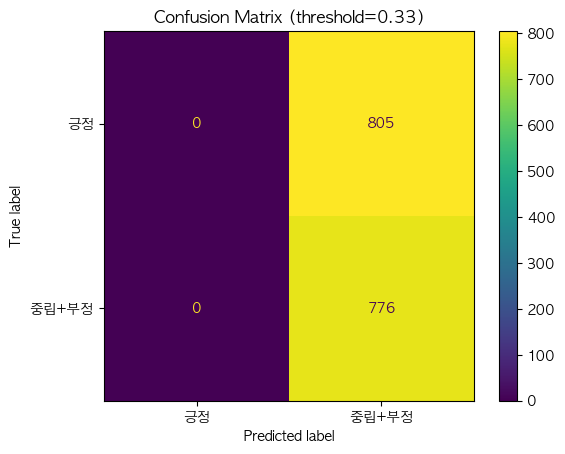


📊 Classification Report:
              precision    recall  f1-score   support

          긍정       0.00      0.00      0.00       805
       중립+부정       0.49      1.00      0.66       776

    accuracy                           0.49      1581
   macro avg       0.25      0.50      0.33      1581
weighted avg       0.24      0.49      0.32      1581



/Users/sunof6/.pyenv/versions/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sunof6/.pyenv/versions/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sunof6/.pyenv/versions/tf_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# ✅ 한글 폰트 설정 (macOS: AppleGothic)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

def plot_confusion_matrix(model, dataloader, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.cpu().numpy()

            output = model(x)
            probs = torch.sigmoid(output).cpu().numpy().flatten()
            preds = (probs > threshold).astype(int)

            all_preds.extend(preds)
            all_labels.extend(y)

    # ✅ 혼동 행렬
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['긍정', '중립+부정'])
    disp.plot(cmap='viridis')
    plt.title(f"Confusion Matrix (threshold={threshold})")
    plt.grid(False)
    plt.show()

    # ✅ 정밀도/재현율/정확도 출력
    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['긍정', '중립+부정']))

plot_confusion_matrix(model, val_loader, threshold=0.33)